In [ ]:
import numpy

import os
from tqdm import tqdm

import dlib
import cv2
import imutils
import time

import matplotlib.pyplot as plt
import shutil
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dlib 
!pip install imutils

### Rename files

In [ ]:
DATASET_NAME = 'new-make'

proj_root = 'drive/MyDrive/colab/deep-make'

data_path = f'{proj_root}/data'
imgs_path = f'{data_path}/{DATASET_NAME}'
crop_path = f'{data_path}/{DATASET_NAME}-crop'

all_files = os.listdir(imgs_path)

### Face detector

In [ ]:
from PIL import Image

detector_path = f'{proj_root}/models/predictor/mmod_human_face_detector.dat'
detector = dlib.cnn_face_detection_model_v1(detector_path)

In [ ]:
def convert_and_trim_bb(image, rect):
    startX = rect.left()
    startY = rect.top()
    endX   = rect.right()
    endY   = rect.bottom()

    startX = max(0, startX)
    startY = max(0, startY)
    endX = min(endX, image.shape[1])
    endY = min(endY, image.shape[0])
    # compute the width and height of the bounding box
    w = endX - startX
    h = endY - startY
    # return our bounding box coordinates
    return (startX, startY, w, h)

def zoom(img, zoom_factor=1.5):
    return cv2.resize(img, None, fx=zoom_factor, fy=zoom_factor)

def extract_face(path, size=512):
    image  = Image.open(path)
    image  = numpy.asarray(image)
    result = detector(image, 2)
    if result:
        (x, y, w, h) = convert_and_trim_bb(image, result[0].rect)
        
#       Small padding for capturing all face landmarks 
        x = max(0, x - 10)
        y = max(0, y - 10)
        w = min(image.shape[1], w + 20)
        h = min(image.shape[0], h + 20)
        return image, (x, y, w, h)
    else:
        return image, (0, 0, size, size)
    

def show(path, max_width=400, show=True):
    image, (x, y, w, h) = extract_face(path, max_width)
    face = image[y : y + h, x : x + w]
    if w < h:
        zoom_factor = (w / image.shape[1])
    else:
        zoom_factor = (h / image.shape[0])
        
    _, axes = plt.subplots(1, 2, figsize=(16, 10))
    if show:
        axes[0].imshow(image)
        axes[1].imshow(face)
    return face

In [ ]:
def get_random_img_path():
    file_path = random.choice(all_files)
    return os.path.join(imgs_path, file_path), file_path

In [ ]:
# for path in tqdm(os.listdir(root)):
#     face = show(f'{root}/{path}', 450, show=False)
#     print(face)
    # plt.imsave(f'{proj_root}/data/crop/{path}', face)

### Face alignment

In [ ]:
import dlib
import numpy as np
import os

from PIL import Image
from imutils.face_utils import FaceAligner
from tqdm import tqdm

import matplotlib.pyplot as plt

In [ ]:
detector  = dlib.get_frontal_face_detector()

# download from dlib.net/files
predictor = dlib.shape_predictor(f'{proj_root}/models/predictor/shape_predictor_68_face_landmarks.dat')

In [ ]:
from collections import OrderedDict
import numpy as np
import cv2

# define a dictionary that maps the indexes of the facial
# landmarks to specific face regions

#For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

# in order to support legacy code, we'll default the indexes to the
# 68-point model
FACIAL_LANDMARKS_IDXS = FACIAL_LANDMARKS_68_IDXS

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [ ]:
import numpy as np
import cv2

class FaceAligner:
    def __init__(
        self, 
        predictor, 
        desiredLeftEye=(0.3, 0.3),
        desiredFaceWidth=400,
        desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        #simple hack ;)
        (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = int((leftEyeCenter[0] + rightEyeCenter[0]) // 2), \
                     int((leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face

        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output

In [ ]:
aligner = FaceAligner(
    predictor,
    desiredLeftEye=(0.25, 0.3),
    desiredFaceWidth=512,
    desiredFaceHeight=512
)

def align(
    path: str,
    aligner: FaceAligner,
):
    img  = Image.open(path).convert("RGB")
    gray = img.convert('L')
    img  = np.asarray(img)
    gray = np.asarray(gray)
    try:
        rect    = detector(img)[0]
        aligned = aligner.align(img, gray, rect)
        return aligned, True
    except:
        return img, False

(<matplotlib.image.AxesImage at 0x7f1b50fea8d0>, True)

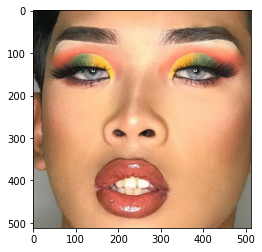

In [ ]:
full_path, _ = get_random_img_path()

img, success = align(
    full_path,
    aligner
)

plt.imshow(img), success

In [ ]:
failures = []

for file in tqdm(os.listdir(imgs_path)):
    file_path = f'{imgs_path}/{file}'
    try:
        img, success = align(file_path, aligner)
        if success:
            plt.imsave(f'{crop_path}/{file}', img)
        else:
            failures.append((file, 'face is too far or huge rotated'))
    except Exception as e:
            failures.append((file, e))

100%|██████████| 1535/1535 [15:26<00:00,  1.66it/s]


In [ ]:
print("Failures: ", len(failures))

Failures:  10


In [ ]:
failures

[('43779595_285772282264523_7786130695033819355_n.png', 'face too far'),
 ('6be8aa6d-07e7-49d8-abf4-18b1e33b12a9.jpg', 'face too far'),
 ('44561911_1278399988968339_8707516829108026390_n.png', 'face too far'),
 ('.DS_Store',
  PIL.UnidentifiedImageError("cannot identify image file 'drive/MyDrive/colab/deep-make/data/new-make/.DS_Store'")),
 ('132026014_215188836751776_3785249101275243737_n.png', 'face too far'),
 ('73045351_534876193735871_5430665115213712915_n.png', 'face too far'),
 ('194261178_793463764567378_1812971362919461915_n.png', 'face too far'),
 ('109359847_901800776964544_5622198294725683790_n.png', 'face too far'),
 ('149372882_248887810162083_7694780845251482648_n.png', 'face too far'),
 ('122060965_203410291146425_4883089951492774639_n.png', 'face too far')]